In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, balanced_accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from typing import List
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from utils import model_metrics

In [2]:
# Define the path to your Parquet file or directory
dataPath = "data_clean2.parquet"  # Adjust for single file or directory
# Read the Parquet data into a DataFrame
df_model = pd.read_parquet(dataPath)

In [3]:
X = df_model.drop(["timestamp_rounded", "label"], axis=1)
y = df_model["label"].map({"Interrupted": 1, "Continue": 0})

In [4]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64", "float32"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Define the numerical transformer
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Define the categorical transformer (if you have categorical features)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

## Baseline model - Logistic regression

In [137]:
pipeline_lg = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(max_iter=10000)),
    ]
)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [139]:
pipeline_lg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['col_0_numeric', 'col_1_numeric', 'col_2_numeric', 'col_3_numeric',
       'col_4_numeric', 'col_5_numeric', 'col_6_numeric', 'col_7_numeric',
       'col_8_numeric', 'col_9_numeric',
       ...
       'col_315_numeric',...
       'col_321_numeric', 'col_323_numeric', 'col_324_numeric',
       'col_325_numeric'],
      dtype='object', length=286)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(max_iter=10000))])

In [140]:
y_pred = pipeline_lg.predict(X_test)
y_pred_proba = pipeline_lg.predict_proba(X_test)[:, 1]

In [172]:
fpr, tpr, roc_auc, recall, precision = model_metrics(y_test, y_pred, y_pred_proba)

Confusion Matrix:
[[181222  58838]
 [  2502  14007]]
Recall: 0.81
Precision: 0.75
ROC AUC: 0.8777175358067524


In [173]:
# Check overfitting
y_pred_train = pipeline_lg.predict(X_train)
y_pred_proba_train = pipeline_lg.predict_proba(X_train)[:, 1]
fpr_train, tpr_train, roc_auc_train, recall_train, precision_train = model_metrics(
    y_train, y_pred_train, y_pred_proba_train
)

Confusion Matrix:
[[725996 234567]
 [  9866  55846]]
Recall: 0.81
Precision: 0.76
ROC AUC: 0.8789634845122424


In [147]:
# Plot ROC Curve
def plot_roc_curve(fpr: List, tpr: List, roc_auc: int):
    """Function to plot ROC curve"""

    plt.figure()
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

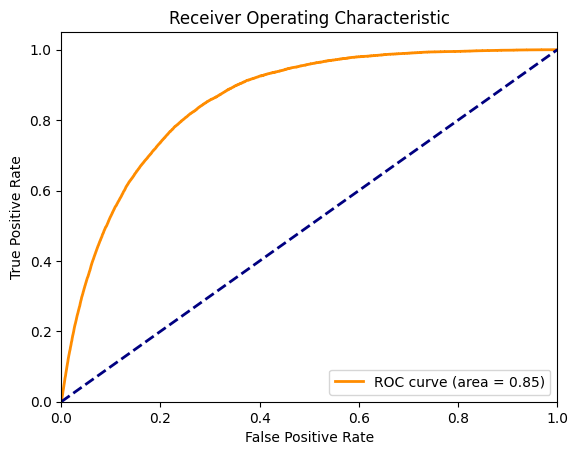

In [29]:
plot_roc_curve(fpr, tpr, roc_auc)

## State of art model - XGBoosting

In [148]:
pipeline_xgb = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier()),
    ]
)

In [149]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['col_0_numeric', 'col_1_numeric', 'col_2_numeric', 'col_3_numeric',
       'col_4_numeric', 'col_5_numeric', 'col_6_numeric', 'col_7_numeric',
       'col_8_numeric', 'col_9_numeric',
       ...
       'col_315_numeric',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [150]:
y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

In [174]:
fpr_xgb, tpr_xgb, roc_auc_xgb, recall_xgb, precision_xgb = model_metrics(
    y_test, y_pred_xgb, y_pred_proba_xgb
)

Confusion Matrix:
[[230577   9483]
 [  7158   9351]]
Recall: 0.50
Precision: 0.96
ROC AUC: 0.9354017579155598


In [160]:
# Check overfitting
y_pred_xgb_train = pipeline_xgb.predict(X_train)
y_pred_proba_xgb_train = pipeline_xgb.predict_proba(X_train)[:, 1]
(
    fpr_xgb_train,
    tpr_xgb_train,
    roc_auc_xgb_train,
    recall_xgb_train,
    precisio_xgb_train,
) = model_metrics(y_train, y_pred_xgb_train, y_pred_proba_xgb_train)

Confusion Matrix:
[[ 10146 950417]
 [    49  65663]]
Recall: 0.94
Precision: 0.01
ROC AUC: 0.547302554502431


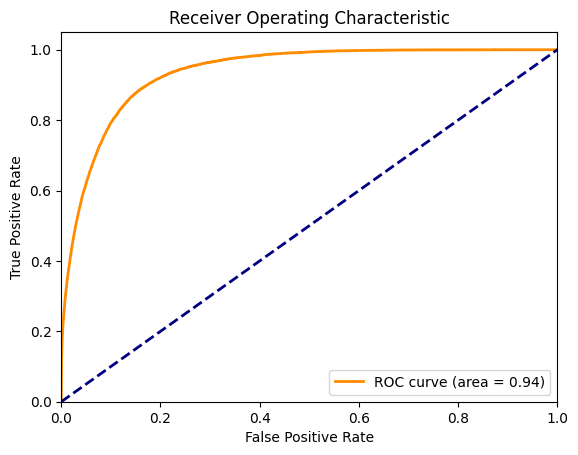

In [152]:
plot_roc_curve(fpr_xgb, tpr_xgb, roc_auc_xgb)

### Hyperparameters optimisation

In [5]:
pipeline_xgb_b = ImbPipeline(
    steps=[
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            XGBClassifier(random_state=0, booster="gbtree", eval_metric="logloss"),
        ),
    ]
)

In [8]:
X_train_pr = pd.DataFrame(
    preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out()
)
X_test_pr = pd.DataFrame(
    preprocessor.fit_transform(X_test), columns=preprocessor.get_feature_names_out()
)

In [9]:
search_spaces = {
    "classifier__learning_rate": Real(0.01, 0.3, "uniform"),
    "classifier__max_depth": Integer(2, 20),
    "classifier__reg_lambda": Real(0.5, 1, "uniform"),  # L2 regularization
    "classifier__reg_alpha": Real(0.5, 1, "uniform"),  # L1 regularization
    "classifier__n_estimators": Integer(50, 1000),
}

scoring = make_scorer(balanced_accuracy_score)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

opt = BayesSearchCV(
    estimator=pipeline_xgb_b,
    search_spaces=search_spaces,
    scoring=scoring,
    cv=skf,
    n_iter=30,  # max number of trials
    n_jobs=1,  # number of jobs                                    # if not iid it optimizes on the cv score
    return_train_score=False,
    optimizer_kwargs={
        "base_estimator": "GP"
    },  # optmizer parameters: we use Gaussian Process (GP)
    random_state=0,
    verbose=5,
)

In [10]:
overdone_control = DeltaYStopper(
    delta=0.0001
)  # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 60 * 4)
callbacks = [overdone_control, time_limit_control]

In [11]:
opt.fit(X_train_pr, y_train, callback=callbacks)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END classifier__learning_rate=0.16397960783612273, classifier__max_depth=14, classifier__n_estimators=642, classifier__reg_alpha=0.8233399705358286, classifier__reg_lambda=0.9293719158275695;, score=0.767 total time= 7.2min
[CV 2/3] END classifier__learning_rate=0.16397960783612273, classifier__max_depth=14, classifier__n_estimators=642, classifier__reg_alpha=0.8233399705358286, classifier__reg_lambda=0.9293719158275695;, score=0.770 total time= 7.2min
[CV 3/3] END classifier__learning_rate=0.16397960783612273, classifier__max_depth=14, classifier__n_estimators=642, classifier__reg_alpha=0.8233399705358286, classifier__reg_lambda=0.9293719158275695;, score=0.766 total time= 7.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END classifier__learning_rate=0.08492778197209695, classifier__max_depth=20, classifier__n_estimators=913, classifier__reg_alpha=0.7996709945862885, classifier__reg_lambda=0.

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
              estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                        ('classifier',
                                         XGBClassifier(base_score=None,
                                                       booster='gbtree',
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric...
                             'classifier__max_depth': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'classifier__n_estimators': Integer(low=50, high=1000, prior='uniform', transform='normalize'),
                             'classifier__reg_alpha': Real(low=0.5, high=1, prior='uniform', transform='normalize'),
                             'classifier__reg_lambda': Real(low=0.5, high=1, prior='uniform', transform='normalize')},
              verbose=5)

In [ ]:
# BayesSearchCV
# Fitting 3 folds for each of 1 candidates, totalling 3 fits
# [CV 1/3] END classifier__learning_rate=0.16397960783612273, classifier__max_depth=14, classifier__n_estimators=642, classifier__reg_alpha=0.8233399705358286, classifier__reg_lambda=0.9293719158275695;, score=0.767 total time= 7.2min
# [CV 2/3] END classifier__learning_rate=0.16397960783612273, classifier__max_depth=14, classifier__n_estimators=642, classifier__reg_alpha=0.8233399705358286, classifier__reg_lambda=0.9293719158275695;, score=0.770 total time= 7.2min
# [CV 3/3] END classifier__learning_rate=0.16397960783612273, classifier__max_depth=14, classifier__n_estimators=642, classifier__reg_alpha=0.8233399705358286, classifier__reg_lambda=0.9293719158275695;, score=0.766 total time= 7.5min
# Fitting 3 folds for each of 1 candidates, totalling 3 fits
# [CV 1/3] END classifier__learning_rate=0.08492778197209695, classifier__max_depth=20, classifier__n_estimators=913, classifier__reg_alpha=0.7996709945862885, classifier__reg_lambda=0.6312621280193786;, score=0.777 total time=77.7min
# [CV 2/3] END classifier__learning_rate=0.08492778197209695, classifier__max_depth=20, classifier__n_estimators=913, classifier__reg_alpha=0.7996709945862885, classifier__reg_lambda=0.6312621280193786;, score=0.781 total time=168.2min
# [CV 3/3] END classifier__learning_rate=0.08492778197209695, classifier__max_depth=20, classifier__n_estimators=913, classifier__reg_alpha=0.7996709945862885, classifier__reg_lambda=0.6312621280193786;, score=0.779 total time=41.3min

In [12]:
pipeline_xgb_b2 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                booster="gbtree",
                eval_metric="logloss",
                learning_rate=0.085,
                max_depth=20,
                n_estimators=913,
                reg_lambda=0.631,
                reg_alpha=0.8,
            ),
        ),
    ]
)
pipeline_xgb_b2.fit(X_train, y_train)
y_pred_xgb2 = pipeline_xgb_b2.predict(X_test)
y_pred_proba_xgb2 = pipeline_xgb_b2.predict_proba(X_test)[:, 1]
fpr_xgb2, tpr_xgb2, roc_auc_xgb2, recall_xgb2, precision_xgb2 = model_metrics(
    y_test, y_pred_xgb2, y_pred_proba_xgb2
)

Confusion Matrix:
[[236251   3809]
 [  6135  10374]]
Recall: 0.27
Precision: 0.98
ROC AUC: 0.9778742834482387


ValueError: not enough values to unpack (expected 5, got 3)

In [118]:
def objective(params):
    # Evaluate the model using cross-validation
    score = cross_val_score(
        pipeline_xgb_b, X_train_pr, y_train, cv=5, scoring="balanced_accuracy"
    ).mean()
    return {"loss": -score, "status": STATUS_OK}


space = {
    "clf__max_depth": hp.choice("max_depth", range(3, 10)),
    "clf__learning_rate": hp.loguniform("learning_rate", -3, 0),
    "clf__n_estimators": hp.quniform("n_estimators", 100, 1000, 1),
    # Add more hyperparameters as needed
}
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print(best)

100%|██████████| 50/50 [8:51:20<00:00, 637.61s/trial, best loss: -0.7498127117052314]   
{'learning_rate': np.float64(0.0690519098691762), 'max_depth': np.int64(4), 'n_estimators': np.float64(968.0)}


In [98]:
# Hyperopt results:
# 100%|██████████| 50/50 [8:51:20<00:00, 637.61s/trial, best loss: -0.7498127117052314]
# {'learning_rate': np.float64(0.0690519098691762), 'max_depth': np.int64(4), 'n_estimators': np.float64(968.0)}

In [176]:
pipeline_xgb_b1 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                booster="gbtree",
                eval_metric="logloss",
                learning_rate=0.069,
                max_depth=4,
                n_estimators=968,
            ),
        ),
    ]
)
pipeline_xgb_b1.fit(X_train, y_train)
y_pred_xgb1 = pipeline_xgb_b1.predict(X_test)
y_pred_proba_xgb1 = pipeline_xgb_b1.predict_proba(X_test)[:, 1]
fpr_xgb1, tpr_xgb1, roc_auc_xgb1, recall_xgb1, precision_xgb1 = model_metrics(
    y_test, y_pred_xgb1, y_pred_proba_xgb1
)

Confusion Matrix:
[[231474   8586]
 [  7537   8972]]
Recall: 0.49
Precision: 0.96
ROC AUC: 0.9346310872157786


In [182]:
model_comparison = pd.DataFrame(
    columns=["model_name", "roc_auc", "recall", "precision"]
)
lg_model = ["Logistic regression", roc_auc, recall, precision]
xgb_model = ["XGBoost basic", roc_auc_xgb, recall_xgb, precision_xgb]
xgb_model_b1 = [
    "XGBoost with Bayes hyperparameter tuning",
    roc_auc_xgb1,
    recall_xgb1,
    precision_xgb1,
]

In [183]:
for i, j in zip(range(3), [lg_model, xgb_model, xgb_model_b1]):
    model_comparison.loc[i] = j

In [184]:
model_comparison

,model_name,roc_auc,recall,precision
0,Logistic regression,0.877718,0.807715,0.754903
1,XGBoost basic,0.935402,0.503504,0.960497
2,XGBoost with Bayes hyperparameter tuning,0.934631,0.489008,0.964234
